# от Бондаренко Алексея (bondaleksey@gmail.com)

Цель данного ноутбука провести моделирование распространения болезни по аэропортам и посмотреть некоторые функции библиотеки работы с графами NetworkX


Основные пункты исследования: 

* реализация функции моделирование распространения болезни,
* оценка скорости распространения болезни,
* исследование графа связности аэропортов и распространения болезни,
* заключение.

In [3]:
import numpy as np 
import pandas as pd

# for graphics 
import matplotlib.pyplot as plt
import seaborn as sns


#technical 
%matplotlib inline
import pickle
import warnings
import contextlib
import time

# 1. Данные

## 1.1 Описание признаков в наборе данных
Приведем [описание](https://docs.microsoft.com/en-us/machine-learning-server/r-reference/revoscaler/airlinedata87to08) набора [данных](https://www.kaggle.com/prajitdatta/data-stories-of-us-airlines) и 
**`выделим`** наиболее значимые признаки.

**Year** - year of the flight (stored as factor).

**Month** - month of the flight (stored as factor).

**`DayOfMonth`** - day of the month (1 to 31) (stored as integer).

**DayOfWeek** - day of the week (stored as factor).

**`DepTime`** - actual departure time (stored as float).

**`CRSDepTime`** - scheduled departure time (stored as float).

**`ArrTime`** - actual arrival time (stored as float).

**`CRSArrTime`** - scheduled arrival time (stored as float).

**UniqueCarrier** - carrier ID (stored as factor).

**FlightNum** - flight number (stored as factor).

**TailNum** - plane's tail number (stored as factor).

**`ActualElapsedTime`** - actual elapsed time of the flight, in minutes (stored as integer).

**CRSElapsedTime** - scheduled elapsed time of the flight, in minutes (stored as integer).

**AirTime** - airborne time for the flight, in minutes (stored as integer).

**ArrDelay** - arrival delay, in minutes (stored as integer).

**DepDelay** - departure delay, in minutes (stored as integer).

**`Origin`** - originating airport (stored as factor).

**`Dest`** - destination airport (stored as factor).

**Distance** - flight distance (stored as integer).

**TaxiIn** - taxi time from wheels down to arrival at the gate, in minutes (stored as integer).

**TaxiOut** - taxi time from departure from the gate to wheels up, in minutes (stored as integer).

**`Cancelled`** - cancellation status (stored as logical).

**CancellationCode** - cancellation code, if applicable (stored as factor).

**`Diverted`** - diversion status (stored as logical).

**CarrierDelay** - delay, in minutes, attributable to the carrier (stored integer).

**WeatherDelay** - delay, in minutes, attributable to weather factors (stored as integer).

**NASDelay** - delay, in minutes, attributable to the National Aviation System (stored as integer).

**SecurityDelay** - delay, in minutes, attributable to security factors (stored as integer).

**LateAircraftDelay** - delay, in minutes, attributable to late-arriving aircraft (stored as integer).

Для моделирования процесса распространения заболевания, требуется определение абсолютного времени взлета и посадки самолета для каждого рейса. Для этого будем использовать следующие признаки: 
DayOfMonth
Origin
Dest
Cancelled
Diverted

## 1.2. Чтение данных 

In [4]:
filename = "../data/airline_dec_2008_50k.csv"
df = pd.read_csv(filename, low_memory=False)
print(df.iloc[:3,:10])
print(df.iloc[:3,10:])

   Unnamed: 0  Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  \
0           1  2008     12           1          1      NaN        1000   
1           2  2008     12           1          1      NaN        1000   
2           3  2008     12           1          1      NaN        1000   

   ArrTime  CRSArrTime UniqueCarrier  
0      NaN        1100            WN  
1      NaN        1110            US  
2      NaN        1125            MQ  
   FlightNum TailNum  ActualElapsedTime  CRSElapsedTime  AirTime  ArrDelay  \
0         16  N366SW                NaN              60      NaN       NaN   
1       2122     NaN                NaN              70      NaN       NaN   
2       3155  N807MQ                NaN              85      NaN       NaN   

   DepDelay Origin Dest  Distance  TaxiIn  TaxiOut  Cancelled  \
0       NaN    HOU  DAL       239     NaN      NaN          1   
1       NaN    LGA  BOS       185     NaN      NaN          1   
2       NaN    SAN  SJC       417     N

In [5]:
print(df.shape)

(50000, 30)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         50000 non-null  int64  
 1   Year               50000 non-null  int64  
 2   Month              50000 non-null  int64  
 3   DayofMonth         50000 non-null  int64  
 4   DayOfWeek          50000 non-null  int64  
 5   DepTime            32968 non-null  float64
 6   CRSDepTime         50000 non-null  int64  
 7   ArrTime            31418 non-null  float64
 8   CRSArrTime         50000 non-null  int64  
 9   UniqueCarrier      50000 non-null  object 
 10  FlightNum          50000 non-null  int64  
 11  TailNum            44556 non-null  object 
 12  ActualElapsedTime  31367 non-null  float64
 13  CRSElapsedTime     50000 non-null  int64  
 14  AirTime            31367 non-null  float64
 15  ArrDelay           31367 non-null  float64
 16  DepDelay           329

In [7]:
df.describe()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,50000.000000,50000.0,50000.0,50000.000000,50000.000000,32968.000000,50000.000000,31418.000000,50000.000000,50000.000000,...,50000.000000,31418.000000,32458.000000,50000.000000,50000.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000
mean,25000.500000,2008.0,12.0,11.350900,3.695000,752.043102,978.930920,791.598829,1076.869720,2592.855480,...,572.158120,7.166879,16.336866,0.355580,0.017080,12.044503,2.584316,18.813327,0.152273,7.957662
std,14433.901067,0.0,0.0,7.843122,1.889499,364.602722,496.930255,193.315743,495.563167,2116.729997,...,446.647873,5.539380,9.846548,0.478693,0.129571,31.444616,13.186963,21.499273,2.125548,29.794825
min,1.000000,2008.0,12.0,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,...,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12500.750000,2008.0,12.0,5.000000,2.000000,612.000000,630.000000,742.000000,805.000000,791.000000,...,261.000000,4.000000,10.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
50%,25000.500000,2008.0,12.0,10.000000,4.000000,657.000000,735.000000,831.000000,910.000000,2021.000000,...,446.000000,6.000000,14.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000
75%,37500.250000,2008.0,12.0,17.000000,5.000000,750.000000,1300.000000,914.000000,1315.000000,4114.000000,...,733.000000,9.000000,20.000000,1.000000,0.000000,14.000000,0.000000,25.000000,0.000000,0.000000
max,50000.000000,2008.0,12.0,31.000000,7.000000,2400.000000,2359.000000,2359.000000,2359.000000,7829.000000,...,3303.000000,156.000000,206.000000,1.000000,1.000000,1092.000000,209.000000,326.000000,96.000000,336.000000


## 1.3  DataFrame с рейсами фактических перелетов между аэропортами

Если рейс был отменен или если рейс перенаправлен, то информацию о таких перелетах извлечем из рассмотрения при моделировании.
Наиболее простой способ это выделить только те рейсы в которых **ActualElapsedTime** не `NaN`

In [8]:
flights = df[df['ActualElapsedTime'].notna()][["Origin","Dest", "DayofMonth", "CRSDepTime", "CRSArrTime","DepTime", "ArrTime","Cancelled","Diverted", "DepDelay","ArrDelay","ActualElapsedTime"]]
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,Cancelled,Diverted,DepDelay,ArrDelay,ActualElapsedTime
17622,SLC,JFK,1,10,629,7.0,659.0,0,0,-3.0,30.0,292.0
17648,SLC,JFK,13,5,626,7.0,631.0,0,0,2.0,5.0,264.0
17666,SLC,JFK,14,5,626,3.0,634.0,0,0,-2.0,8.0,271.0
17700,SLC,JFK,15,5,626,2.0,602.0,0,0,-3.0,-24.0,240.0
18122,DFW,TUL,20,2310,5,3.0,58.0,0,0,53.0,53.0,55.0


Преобразуем столбцы некоторые признаки к типу данных int64

In [9]:
to_int_32_dict={"DepTime":"int64",
                "ArrTime":"int64",
                "DepDelay":"int64",
                "ActualElapsedTime":"int64"}

In [10]:
flights=flights.astype(to_int_32_dict)
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,Cancelled,Diverted,DepDelay,ArrDelay,ActualElapsedTime
17622,SLC,JFK,1,10,629,7,659,0,0,-3,30.0,292
17648,SLC,JFK,13,5,626,7,631,0,0,2,5.0,264
17666,SLC,JFK,14,5,626,3,634,0,0,-2,8.0,271
17700,SLC,JFK,15,5,626,2,602,0,0,-3,-24.0,240
18122,DFW,TUL,20,2310,5,3,58,0,0,53,53.0,55


Проверим, что нет `NaN` и нет отмененных и перенаправленных рейсов.

In [11]:
flights[["DepTime"]].isna().sum()

DepTime    0
dtype: int64

In [12]:
flights[["ArrTime"]].isna().sum()

ArrTime    0
dtype: int64

In [13]:
flights[["Cancelled"]].sum()

Cancelled    0
dtype: int64

In [14]:
flights[["Diverted"]].sum()

Diverted    0
dtype: int64

In [15]:
flights.shape

(31367, 12)

In [16]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31367 entries, 17622 to 49999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Origin             31367 non-null  object 
 1   Dest               31367 non-null  object 
 2   DayofMonth         31367 non-null  int64  
 3   CRSDepTime         31367 non-null  int64  
 4   CRSArrTime         31367 non-null  int64  
 5   DepTime            31367 non-null  int64  
 6   ArrTime            31367 non-null  int64  
 7   Cancelled          31367 non-null  int64  
 8   Diverted           31367 non-null  int64  
 9   DepDelay           31367 non-null  int64  
 10  ArrDelay           31367 non-null  float64
 11  ActualElapsedTime  31367 non-null  int64  
dtypes: float64(1), int64(9), object(2)
memory usage: 3.1+ MB


In [17]:
flights.describe()

,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,Cancelled,Diverted,DepDelay,ArrDelay,ActualElapsedTime
count,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.0,31367.0,31367.000000,31367.000000,31367.000000
mean,7.209488,739.032231,800.524437,715.190806,791.311984,0.0,0.0,1.124940,0.342813,109.631555
std,4.686065,331.297472,210.604854,314.193024,192.926966,0.0,0.0,20.289293,24.317448,54.238003
min,1.000000,5.000000,1.000000,1.000000,1.000000,0.0,0.0,-28.000000,-71.000000,25.000000
25%,3.000000,614.000000,745.000000,610.000000,742.000000,0.0,0.0,-5.000000,-11.000000,71.000000
50%,7.000000,700.000000,835.000000,654.000000,831.000000,0.0,0.0,-3.000000,-4.000000,97.000000
75%,10.000000,740.000000,915.000000,740.000000,914.000000,0.0,0.0,0.000000,5.000000,135.000000
max,31.000000,2359.000000,2359.000000,2400.000000,2359.000000,0.0,0.0,1092.000000,1103.000000,457.000000


In [18]:
flights=flights.drop(columns=["Cancelled","Diverted"]);

In [19]:
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ArrDelay,ActualElapsedTime
17622,SLC,JFK,1,10,629,7,659,-3,30.0,292
17648,SLC,JFK,13,5,626,7,631,2,5.0,264
17666,SLC,JFK,14,5,626,3,634,-2,8.0,271
17700,SLC,JFK,15,5,626,2,602,-3,-24.0,240
18122,DFW,TUL,20,2310,5,3,58,53,53.0,55


 ## 1.4 Определим фактическое время вылета

Для определения абсолютного времени, нам необходимо узнать смещение локального времени аэропорта относительно GMT времени. Для этого используем результаты [открытого проекта](https://github.com/opentraveldata/opentraveldata/blob/master/opentraveldata/optd_por_public.csv),
а сам файл с информацией об открытых аэропортах(11Mb) доступен по [ссылке](https://raw.githubusercontent.com/opentraveldata/opentraveldata/master/opentraveldata/optd_por_public.csv).
Для дополнительной можно использовать сервис, где информация об YUM выдается по [запросу](https://airports-api.s3-us-west-2.amazonaws.com/iata/yum.json).

Результаты для аэропортов из `flights` получены скриптом **prepare_gtm_offset.py** и сохранены в словаре в файле  "..\data\airports_gmt_offset_int.pkl" .

In [20]:
with open('../data/airports_gmt_offset_int.pkl','rb') as f:
    airport_time_offset = pickle.load(f)

In [21]:
for key, val in airport_time_offset.items():
    if key<"B":
        print(f"Key = {key} : val = {val}")                

Key = ABE : val = -5
Key = ABI : val = -6
Key = ABQ : val = -7
Key = ABY : val = -5
Key = ACT : val = -6
Key = ACV : val = -8
Key = ADQ : val = -9
Key = AEX : val = -6
Key = AGS : val = -5
Key = ALB : val = -5
Key = AMA : val = -6
Key = ANC : val = -9
Key = ASE : val = -7
Key = ATL : val = -5
Key = ATW : val = -6
Key = AUS : val = -6
Key = AVL : val = -5
Key = AVP : val = -5
Key = AZO : val = -5


Дополним таблицу `flights` столбцом абсолютного времени вылета в минутах по отношению к 1 декабря GMT(0-00) 2008 года.

In [22]:
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ArrDelay,ActualElapsedTime
17622,SLC,JFK,1,10,629,7,659,-3,30.0,292
17648,SLC,JFK,13,5,626,7,631,2,5.0,264
17666,SLC,JFK,14,5,626,3,634,-2,8.0,271
17700,SLC,JFK,15,5,626,2,602,-3,-24.0,240
18122,DFW,TUL,20,2310,5,3,58,53,53.0,55


Так как у вылета при изменении времени вылета изменений в его фактическом дне вылета не происходит, то для расчетов абсолютных  времен вылета и прилета надо пользоваться:
- DayofMonth
- CRSDepTime/CRSArrTime
- DepDelay/ArrDelay

Но так как может быть ночной перелет, то надо к фактическому времени вылета добавить время на полет

In [23]:
# Определим функции  вычисления длительности полета 
def gtm_time_dep(airport, day, crs, delay):
    """Calculate gmt time of departure in minutes according data format"""
    return (day-1)*24*60 + int(crs/100)*60 + crs%100 + delay + airport_time_offset[airport]*60

def gtm_time_arr(gtmDep, eltime ):
    """Calculate gmt time of arrival in minutes according data format"""
    return gtmDep + eltime

In [24]:
flights["gtm_origin"] = flights.apply(lambda x: airport_time_offset[x.Origin], axis=1)
flights["gtm_dest"] = flights.apply(lambda x: airport_time_offset[x.Dest], axis=1)

In [25]:
flights["gmtDep"] = flights.apply(lambda x: gtm_time_dep(x.Origin, x.DayofMonth, x.CRSDepTime, x.DepDelay), axis=1)

In [26]:
flights["gmtArr"] = flights["gmtDep"]+flights["ActualElapsedTime"]
#flights.apply(lambda x: gtm_time_arr(x.gmtDep, x.ActualElapsedTime), axis=1)

Отсортируем данные по дням и времени вылета

In [27]:
flights=flights.sort_values(by=["gmtDep"])

In [28]:
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ArrDelay,ActualElapsedTime,gtm_origin,gtm_dest,gmtDep,gmtArr
18609,ANC,SEA,1,30,449,28,440,-2,-9.0,192,-9,-8,-512,-320
18854,ANC,PDX,1,100,532,56,514,-4,-18.0,198,-9,-8,-484,-286
19409,ANC,SLC,1,110,743,108,744,-2,1.0,276,-9,-7,-472,-196
18606,LAX,MSP,1,20,553,16,616,-4,23.0,240,-8,-6,-464,-224
18610,SFO,MSP,1,25,556,30,611,5,15.0,221,-8,-6,-450,-229


In [29]:
flights.tail()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ArrDelay,ActualElapsedTime,gtm_origin,gtm_dest,gmtDep,gmtArr
24710,IAD,MCO,31,2155,9,2224,26,29,17.0,122,-5,-5,44244,44366
24713,DFW,AUS,31,2325,20,2327,9,2,-11.0,42,-6,-6,44247,44289
24707,SJU,JFK,31,2100,1,2145,53,45,52.0,248,-4,-5,44265,44513
19223,ORD,BUF,31,2141,15,3,237,142,142.0,94,-6,-5,44283,44377
24712,JFK,ROC,31,2235,1,2327,35,52,34.0,68,-5,-5,44307,44375


## 1.5  Рассмотрим подробнее очищенные данные

In [30]:
flights.describe()

,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ArrDelay,ActualElapsedTime,gtm_origin,gtm_dest,gmtDep,gmtArr
count,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.00000,31367.000000
mean,7.209488,739.032231,800.524437,715.190806,791.311984,1.124940,0.342813,109.631555,-6.149456,-6.208882,9026.22852,9135.860076
std,4.686065,331.297472,210.604854,314.193024,192.926966,20.289293,24.317448,54.238003,1.276300,1.234447,6776.72387,6783.911373
min,1.000000,5.000000,1.000000,1.000000,1.000000,-28.000000,-71.000000,25.000000,-10.000000,-10.000000,-512.00000,-320.000000
25%,3.000000,614.000000,745.000000,610.000000,742.000000,-5.000000,-11.000000,71.000000,-7.000000,-7.000000,3583.00000,3752.500000
50%,7.000000,700.000000,835.000000,654.000000,831.000000,-3.000000,-4.000000,97.000000,-6.000000,-6.000000,8703.00000,8805.000000
75%,10.000000,740.000000,915.000000,740.000000,914.000000,0.000000,5.000000,135.000000,-5.000000,-5.000000,13105.00000,13229.000000
max,31.000000,2359.000000,2359.000000,2400.000000,2359.000000,1092.000000,1103.000000,457.000000,-4.000000,-4.000000,44307.00000,44513.000000


### 1.5.1 Длительность полета

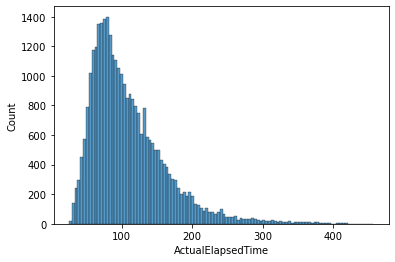

In [31]:
sns.histplot(flights["ActualElapsedTime"]);
#sns.distplot
#histplot
#displot

### 1.5.2 Посмотреть число рейсов по дням

In [32]:
number_of_flights_per_day = [ (flights["DayofMonth"]==i).sum() for i in range(1,32,1)]

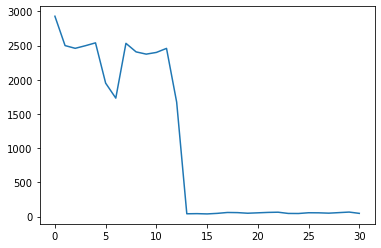

In [33]:
plt.plot(number_of_flights_per_day);

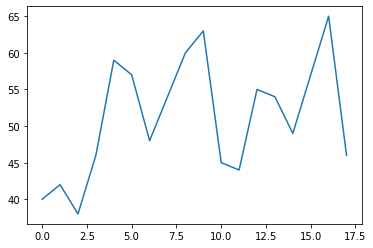

In [34]:
plt.plot(number_of_flights_per_day[13:]);

# 2. Моделирование распространения болезни между аэропортами

## 2.1 DataFrame для модулирования

Для дальнейшей работы нам достаточно столбцов:
- Аэропорты вылета(**Origin**) и прилета(**Dest**),
- абсолютное время в минутах вылета (**gmtDep**) и посадки(**gmtArr**) 

In [35]:
df4sim = flights[['Origin','Dest','gmtDep','gmtArr']].copy()

In [36]:
df4sim.head(10)

,Origin,Dest,gmtDep,gmtArr
18609,ANC,SEA,-512,-320
18854,ANC,PDX,-484,-286
19409,ANC,SLC,-472,-196
18606,LAX,MSP,-464,-224
18610,SFO,MSP,-450,-229
18611,SMF,IAH,-446,-242
19414,ANC,SEA,-446,-252
18612,SFO,IAH,-445,-251
18613,LAS,JFK,-442,-134
18615,SEA,MSP,-437,-249


Определим количество уникальных аэропортов

In [37]:
unique_airports = np.unique(df4sim[['Origin','Dest']])
unique_Origin_airports = np.unique(df4sim[['Origin']])
unique_Dest_airports = np.unique(df4sim[['Dest']])
Nua=len(unique_airports)
print(len(unique_airports))
print(len(unique_Origin_airports))
print(len(unique_Dest_airports))

266
260
207


## 2.2 Функция моделирования (симуляции) одного прохода по всему списку перелетов

In [38]:
def one_simulation(df, contagious=0.5, start="All"):
    """_summary_

    Args:
        df (_type_): _description_
        contagious (float, optional): _description_. Defaults to 0.5.
        start (str, optional): _description_. Defaults to "All".

    Returns:
        _type_: _description_
    """            
    # we have set of airports which will be contagious when flight arrives
    
    
    # history - is a dictionary with
    # airport : time when it became contagious
    ill=set()
    if start=="All":
        ill.add(df.Origin.iloc[0])
        history = {df.Origin.iloc[0]: df.gmtDep.iloc[0]}
    else:        
        ill.add(df.Origin[df.Origin == start].iloc[0])
        history = {df.Origin[df.Origin == start].iloc[0]: df.gmtDep[df.Origin == start].iloc[0]}
        print(df[df.Origin == start].iloc[0])    
    
    for row in df.itertuples():        
        if (row.Origin in ill) and (row.Dest not in ill):
            # надо проверить, а зараженный уже точно успел заразиться или еще нет? 
            if row.gmtDep > history[row.Origin]:
                if np.random.random()<contagious:
                    ill.add(row.Dest)
                    history[row.Dest] = row.gmtArr                                    
    return history

In [39]:
# compare with one_simulation and its time = 18.7 ms ± 51.4 µs per loop
np.random.seed(3047)
hist = one_simulation(df4sim,0.01)

In [40]:
len(hist)

20

In [41]:
print(hist)

{'ANC': -512, 'SLC': 7002, 'PHX': 7316, 'SNA': 8840, 'ELP': 11564, 'LAS': 11657, 'PDX': 11748, 'SEA': 12753, 'FAI': 12845, 'SJC': 14477, 'SMF': 14504, 'DAL': 15893, 'ADQ': 17217, 'DFW': 17345, 'SFO': 17283, 'CMH': 26758, 'MSP': 27151, 'IAH': 28562, 'JFK': 28676, 'FLL': 35594}


## 2.3 Моделирование при разных значениях коэффициента заразности p 

Функция моделирования для разных значений коэффициента заразности p имеет вид:

In [42]:
def simulate(df,p, Nsim=3):
    """_summary_

    Args:
        p (_type_): _description_
        
    Returns:
        _type_: _description_
    """    
    np.random.seed(3047)
    def inner(p_index, N):
        return [one_simulation(df,p_index) for _ in range(N)]    
    return {index:inner(index, Nsim) for index in p}

In [43]:
# many_p = np.concatenate((np.linspace(0.01,0.1,10), np.linspace(0.2,1,9)))
p_values = [0.01, 0.05, 0.1, 0.5, 1]
Nsim = 3

Осуществим моделирование для p равных `p_values` и число экспериментов для одного p равно `Nsim`.

In [44]:
result = simulate(df4sim, p_values, Nsim)

In [45]:
print(result.keys())

dict_keys([0.01, 0.05, 0.1, 0.5, 1])


## 2.4 Анализ результатов моделирования разных значений заразности

Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени. Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей. 

То есть накопленный процент зараженных аэропортов посчитанный с некоторым шагом dt = 12 часов или любым другим шагом, или просто при заданном массиве dt_mas

Преобразуем дынные моделирования для удобства анализа зависимости `зараженности от времени`.  

In [46]:
def get_data_4_analysis(result):
    """_summary_

    Args:
        result (_type_): _description_

    Returns:
        _type_: _description_
    """    
    data_analysis = []    
    for p, model in result.items():
        nparr = np.array([])
        for j in range(len(model)):        
            q = (np.array(list(model[j].values())))
            nparr=np.concatenate((nparr,q))            
        nparr.sort()
        data_analysis.append(nparr)
            # np.concatenate(nparr,np.array(model[j].values()))
    return data_analysis

In [47]:
data = get_data_4_analysis(result)
for j in range(len(data)):
    print(data[j].shape)

(65,)
(222,)
(450,)
(580,)
(612,)


Дополнительные функции для анализа зависимости `зараженности от времени`. 

In [48]:
def infected_over_time(nparr, Nsim, Nua ,dt = 12*60):
    """_summary_

    Args:
        nparr (_type_): _description_
        Nsim (_type_): _description_
        Nua (_type_): _description_
        dt (_type_, optional): _description_. Defaults to 12*60.

    Returns:
        _type_: _description_
    """    
    mz = nparr.min()
    # N_intervals = np.ceil((nparr.max() - nparr.min())/dt)
    # N_intervals = (int(N_intervals))
    
    # hist, _ = np.histogram(nparr, bins=int(N_intervals),range=(mz,mz+N_intervals*dt))    
    hist, _ = np.histogram(nparr, bins=62,range=(mz,mz+62*dt))    
    cshist = hist.cumsum()/(Nsim*Nua)    
    cshist = np.insert(cshist,0,0)
    return cshist 
def x_4_infected_over_time(nparr, dt = 12*60):
    """_summary_

    Args:
        nparr (_type_): _description_
        dt (_type_, optional): _description_. Defaults to 12*60.

    Returns:
        _type_: _description_
    """    
    # N_intervals = int(np.ceil((nparr.max() - nparr.min())/dt))    
    
    N_intervals = int(np.ceil(31*24*60/dt + 1))    
    # x = [(i+1)*dt for i in range(N_intervals)]    
    return [(i)*dt for i in range(N_intervals)]    

Функция построения графика

In [49]:
def draw_proportions(data_values, p_values, Nsim, Nua, dt=12*60):
    """_summary_

    Args:
        data_values (_type_): _description_
        p_values (_type_): _description_
        Nsim (_type_): _description_
        Nua (_type_): _description_
        dt (_type_, optional): _description_. Defaults to 12*60.

    Returns:
        _type_: _description_
    """    
    if len(p_values)!=len(data_values):
        print("We have different length for 'p' and 'data'")
        return None        
    for p1, data in zip(p_values,data_values):   
        percent = infected_over_time(data, Nsim, Nua, dt)            
        x = x_4_infected_over_time(data, dt)                
        plt.plot(x, percent,label=f'p = {p1}')        
        
    xdays = [24*60*(i+1) for i in range(31) if i%2==0]
    ndays = [i+1 for i in range(31) if i%2==0]
    plt.xticks(xdays, ndays)
    plt.ylim((0,1))
    plt.xlim((0,32*24*60))
    plt.grid(visible=True)
    plt.legend()
    plt.show();

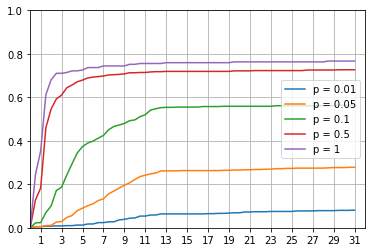

In [50]:
draw_proportions(data, p_values, Nsim, Nua)

## 2.5 Заключение по результатам анализа зараженности от времени
Всего аэропортов - 266
Число аэропортов откуда осуществляются вылеты - 260
Число аэропортов, в которые прилетают - 207
Поэтому доля аэропотртов, которые не могут быть заражены согласно данному расписанию составляет $\frac{266-207}{266} = 0.22 \%$

In [51]:
(266-207)/266

0.22180451127819548

Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени. Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей.

Описать почему другие не так растут ... в конце исследования, когда станет понятна связность графа

# 3. Исследование графа связности аэропортов и распространения болезни

q = Может ли информация о сети помочь предсказать, кто будет заражен?

q1 = Настало время поработать с NetworkX. По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.

q2 = Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города

q3 = Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality)

q4 = Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?

## 3.1 Граф аэропортов

Вес ребра - относительное число перелетов

Вес вершины = сколько входит ребер (прилетов) (Сделать разметку на этом графе какие вершины имеют 0, от 1 до 3 входящих ребер, от 4 до 6, более 6 другой цвет)
надо посмотреть на связность вершин, есть ли "узкое горлышко"? 

Надо граф построить 

вершины - это аэропорты, вес = число вхождений в вершину

ребра - это перелеты, вес = число перелетов относительно всех перелетов

1 Как задавать граф 
2 подсчитать, вес ребра, вес вершины

## 3.2 Моделирование характеристики `медианное время на заражение`

Лист аэропортов есть, надо функции обработки данных моделирования при p = 0.5

In [54]:
result2 = simulate(df4sim, [0.5], 4)

In [86]:
df_contagious_time = pd.DataFrame(columns=unique_airports)
print(df_contagious_time.head())

Empty DataFrame
Columns: [ABE, ABI, ABQ, ABY, ACT, ACV, ADQ, AEX, AGS, ALB, AMA, ANC, ASE, ATL, ATW, AUS, AVL, AVP, AZO, BDL, BET, BFL, BGM, BGR, BHM, BIL, BIS, BMI, BNA, BOI, BOS, BQK, BQN, BRO, BTM, BTR, BTV, BUF, BUR, BWI, BZN, CAE, CAK, CDC, CEC, CHA, CHO, CHS, CIC, CID, CLD, CLE, CLT, CMH, CMI, CMX, COD, COS, CPR, CRP, CRW, CSG, CVG, CWA, DAB, DAL, DAY, DBQ, DCA, DEN, DFW, DHN, DLH, DRO, DSM, DTW, EGE, EKO, ELP, ERI, EUG, EVV, EWN, EWR, EYW, FAI, FAR, FAT, FAY, FCA, FLG, FLL, FLO, FNT, FSD, FSM, FWA, GCC, GEG, GFK, ...]
Index: []

[0 rows x 266 columns]


In [69]:
# print(type(result2[0.5]))
# print((result2[0.5]))

In [87]:
# df_contagious_time = pd.DataFrame.from_dict(result2[0.5])
df_contagious_time = df_contagious_time.append(result2[0.5])

In [92]:
df_contagious_time.head()

,ABE,ABI,ABQ,ABY,ACT,ACV,ADQ,AEX,AGS,ALB,...,TVC,TWF,TXK,TYR,TYS,VLD,VPS,WRG,XNA,YUM
0,1595,NaN,95,NaN,NaN,1493,5696,NaN,1711,1637,...,NaN,117,NaN,NaN,1598,NaN,4558,1490,1759,138.0
1,3012,NaN,1527,NaN,NaN,1493,1392,NaN,5981,3083,...,NaN,1563,NaN,NaN,3035,NaN,1678,2884,1605,NaN
2,1595,NaN,95,NaN,NaN,1493,-58,NaN,1711,3083,...,NaN,2994,NaN,NaN,1651,NaN,5997,2884,192,NaN
3,1595,NaN,163,NaN,NaN,1493,-58,NaN,1711,1681,...,NaN,1563,NaN,NaN,1598,NaN,1678,2884,1605,NaN


In [75]:
(-286+124*3)/4

21.5

In [93]:
mean_ct = df_contagious_time.mean()

In [100]:
print(mean_ct.isna().sum())

64


In [102]:
print(mean_ct['ABQ'])
print(type(mean_ct))

470.0
<class 'pandas.core.series.Series'>


In [103]:
contagious_time = mean_ct.to_dict()

#### `НАДО ЛИ Выбросить NAN и что с ними лучше сделать по смыслу??? `

In [104]:
print(type(contagious_time))
print(contagious_time)

<class 'dict'>
{'ABE': 1949.25, 'ABI': nan, 'ABQ': 470.0, 'ABY': nan, 'ACT': nan, 'ACV': 1493.0, 'ADQ': 1743.0, 'AEX': nan, 'AGS': 2778.5, 'ALB': 2371.0, 'AMA': 1607.0, 'ANC': -512.0, 'ASE': 855.0, 'ATL': 1242.25, 'ATW': 3057.0, 'AUS': 894.0, 'AVL': 3083.0, 'AVP': 4296.5, 'AZO': nan, 'BDL': 1460.75, 'BET': 2131.0, 'BFL': 4422.75, 'BGM': nan, 'BGR': nan, 'BHM': 1238.75, 'BIL': 2691.75, 'BIS': 40564.5, 'BMI': 1631.0, 'BNA': 1235.75, 'BOI': 2142.0, 'BOS': 1091.75, 'BQK': nan, 'BQN': 4950.5, 'BRO': 4533.5, 'BTM': nan, 'BTR': 1302.0, 'BTV': 8934.0, 'BUF': 1446.25, 'BUR': 508.5, 'BWI': 1306.75, 'BZN': nan, 'CAE': 2754.5, 'CAK': 1721.5, 'CDC': nan, 'CEC': 4370.5, 'CHA': 4105.666666666667, 'CHO': nan, 'CHS': 2385.5, 'CIC': nan, 'CID': 2385.5, 'CLD': 2926.75, 'CLE': 1615.25, 'CLT': 1502.75, 'CMH': 1615.5, 'CMI': 1203.0, 'CMX': nan, 'COD': nan, 'COS': 1923.5, 'CPR': 1964.0, 'CRP': 1620.0, 'CRW': nan, 'CSG': nan, 'CVG': 1569.5, 'CWA': nan, 'DAB': nan, 'DAL': 1434.75, 'DAY': 1701.25, 'DBQ': 1083.0

## 3.3 Характеристики графа аэропортов

## 3.4 
Для каждого аэропорта по x - среднее время на заражение, по y - одна из характеристик графа